# Анализ датасета книг

Датасет - Goodreads' Best Books Ever 

https://www.kaggle.com/datasets/meetnaren/goodreads-best-books?select=book_data.csv





In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

In [3]:
from google.colab import files

In [56]:
df = pd.read_csv('/content/sample_data/book_data.csv')
df.head(4)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_authors       54301 non-null  object 
 1   book_desc          52970 non-null  object 
 2   book_edition       5453 non-null   object 
 3   book_format        52645 non-null  object 
 4   book_isbn          41435 non-null  object 
 5   book_pages         51779 non-null  object 
 6   book_rating        54301 non-null  float64
 7   book_rating_count  54301 non-null  int64  
 8   book_review_count  54301 non-null  int64  
 9   book_title         54301 non-null  object 
 10  genres             51059 non-null  object 
 11  image_url          53618 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.0+ MB


# Подготовка данных 

Подготовим данные для анализа: уберем столбцы **image_url, book_isbn, book_desc, book_authors, book_edition, book_title**

In [57]:
df = df.drop(['image_url', 'book_isbn', 'book_desc', 'book_authors', 'book_edition', 'book_title'], axis=1)

df['genres'].fillna('', inplace=True)
df['genre_count'] = [len(i.split('|')) for i in df.loc[:, 'genres']]

df.head(4)

,book_format,book_pages,book_rating,book_rating_count,book_review_count,genres,genre_count
0,Hardcover,374 pages,4.33,5519135,160706,Young Adult|Fiction|Science Fiction|Dystopia|F...,6
1,Paperback,870 pages,4.48,2041594,33264,Fantasy|Young Adult|Fiction,3
2,Paperback,324 pages,4.27,3745197,79450,Classics|Fiction|Historical|Historical Fiction...,6
3,Paperback,279 pages,4.25,2453620,54322,Classics|Fiction|Romance,3


Представим столбцы **book_pages** и **book_format** в числовом формате: 

В **book_format** сделаем 3 категории: 0 - бумажная обложка (объединим значения Paperback и Mass Market Paperback, 1 - твердая обложка, 2 - электронный формат (объединим значения Kindle Edition и ebook), 3 - аудио формат

В **book_pages** уберем слово page

In [59]:
df['book_format'].value_counts()

Paperback                          28725
Hardcover                          12163
Kindle Edition                      5436
Mass Market Paperback               2668
ebook                               2534
                                   ...  
Flexibound                             1
Gebunden                               1
Paperback, Kindle, Ebook, Audio        1
Hard Cover                             1
Bantam New Fiction                     1
Name: book_format, Length: 147, dtype: int64

In [8]:
df['genres'].value_counts()

                                                                                                         3242
Fiction                                                                                                   234
Novels                                                                                                    194
Poetry                                                                                                    169
Science Fiction|Fiction                                                                                   156
                                                                                                         ... 
Fiction|Contemporary|Music|Mental Health|Mental Illness                                                     1
Fantasy|Fiction|Young Adult|Christian Fiction|Christian|Christian Fiction|Christian Fantasy|Childrens       1
Fiction|Food and Drink|Food|Romance|Contemporary                                                            1
Poetry|Phi

In [52]:
def format_pages(row):
  if not pd.isna(row['book_pages']):
    return int(row['book_pages'].split(' ')[0])

df['book_pages'] = df.apply(lambda row: format_pages(row), axis=1)

In [53]:
def format_book(row):
  if not pd.isna(row['book_format']):
    if row['book_format'] in ['Paperback', 'Mass Market Paperback']:
      return 0
    elif row['book_format'] in ['Hardcover']:
      return 1
    elif row['book_format'] in ['Kindle Edition', 'ebook']:
      return 2
    elif 'Audio' in row['book_format']:
      return 3
    else:
      return np.NaN

df['book_format'] = df.apply(lambda row: format_book(row), axis=1)

Посмотрим, какие жанры самые популярные

In [54]:
genres = {}

genres_dummies = df['genres'].str.get_dummies('|')

print(genres_dummies.columns)

df = df.drop(['genres'], axis=1)

for col in genres_dummies.columns:
  genres[col] = genres_dummies[col].sum()

genres = dict(sorted(genres.items(), key=lambda item: -item[1]))

genres

Index(['10th Century', '11th Century', '12th Century', '13th Century',
       '14th Century', '15th Century', '16th Century', '17th Century',
       '18th Century', '1917',
       ...
       'Young Adult Fantasy', 'Young Adult Historical Fiction',
       'Young Adult Paranormal', 'Young Adult Romance', 'Young Readers',
       'Yuri', 'Zen', 'Zimbabwe', 'Zombies', '漫画'],
      dtype='object', length=866)


{'Fiction': 26007,
 'Fantasy': 14295,
 'Romance': 12899,
 'Young Adult': 10533,
 'Nonfiction': 7727,
 'Historical': 7120,
 'Historical Fiction': 6408,
 'Classics': 6316,
 'Contemporary': 6064,
 'Mystery': 5681,
 'Paranormal': 5176,
 'Science Fiction': 5136,
 'Cultural': 4972,
 'Childrens': 3966,
 'Literature': 3792,
 'Thriller': 3045,
 'European Literature': 2954,
 'History': 2683,
 'Novels': 2553,
 'Biography': 2370,
 'Horror': 2316,
 'Adventure': 2267,
 'Humor': 2151,
 'Contemporary Romance': 2115,
 'Crime': 2080,
 'Philosophy': 1940,
 'Short Stories': 1847,
 'Religion': 1817,
 'Autobiography': 1763,
 'Sequential Art': 1726,
 'Paranormal Romance': 1709,
 'Vampires': 1695,
 'Memoir': 1658,
 'Womens Fiction': 1649,
 'Chick Lit': 1641,
 'Christian': 1616,
 'Urban Fantasy': 1528,
 'New Adult': 1467,
 'Graphic Novels': 1452,
 'War': 1450,
 'Adult Fiction': 1422,
 'Dystopia': 1413,
 'Magic': 1398,
 'Comics': 1347,
 'Poetry': 1323,
 'Middle Grade': 1266,
 'Realistic Fiction': 1176,
 'Erotic

In [13]:
df.isna().sum()

book_format          2369
book_pages           2522
book_rating             0
book_rating_count       0
book_review_count       0
genres_count            0
dtype: int64

Заменим в нужных нам столбцах NaN на моду

In [15]:
for col in df.columns:
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)

In [15]:
df.describe()

,book_format,book_pages,book_rating,book_rating_count,book_review_count,genres_count
count,54301.000000,54301.000000,54301.000000,5.430100e+04,54301.00000,54301.0
mean,0.539972,336.842489,4.020027,4.350449e+04,2011.60218,9.0
std,0.766044,253.461514,0.362100,2.126572e+05,7627.07287,0.0
min,0.000000,0.000000,0.000000,0.000000e+00,0.00000,9.0
25%,0.000000,224.000000,3.830000,4.070000e+02,35.00000,9.0
50%,0.000000,320.000000,4.030000,2.811000e+03,188.00000,9.0
75%,1.000000,398.000000,4.220000,1.274500e+04,822.00000,9.0
max,3.000000,14777.000000,5.000000,5.588580e+06,160776.00000,9.0


In [ ]:
t = df['book_pages'].mode()
print(f'Самое популярное количество страниц: {list(t)}')

Самое популярное количество страниц: [320.0]


In [ ]:
t = df['book_rating'].mode()[0]
print(f'Самый популярный рейтинг: {t}')

Самый популярный рейтинг: 3.98


In [ ]:
t = df['book_format'].mode()
print(f'Самый популярный формат: {list(t)} - Мягкая обложка')

Самый популярный формат: [0.0] - Мягкая обложка


# Анализ

Посмотрим внимательно на следующие значения:

* book_pages - количество страниц в книге
* book_rating - рейтинг книги
* book_rating_count - количество оценок книги
* book_review_count - количество ревью на книгу 
* book_format - формат книги 

Среднее количество страниц - 320, что очень близко к значению 50% квантиля, стоит проверить количество страниц на нормальность

Средний рейтинг так же очень близок к зачению 50% квантиля, стоит проверить рейтинг на нормальность

Среднее количество оценок и ревью сильно отличается от их медианы - скорее всего популярные книги сильно увеличивают среднее значение 

Формат книги - как можно видеть, большая часть книг в выборке - в бумажном формате 

# Проверка параметров на нормальное распределение

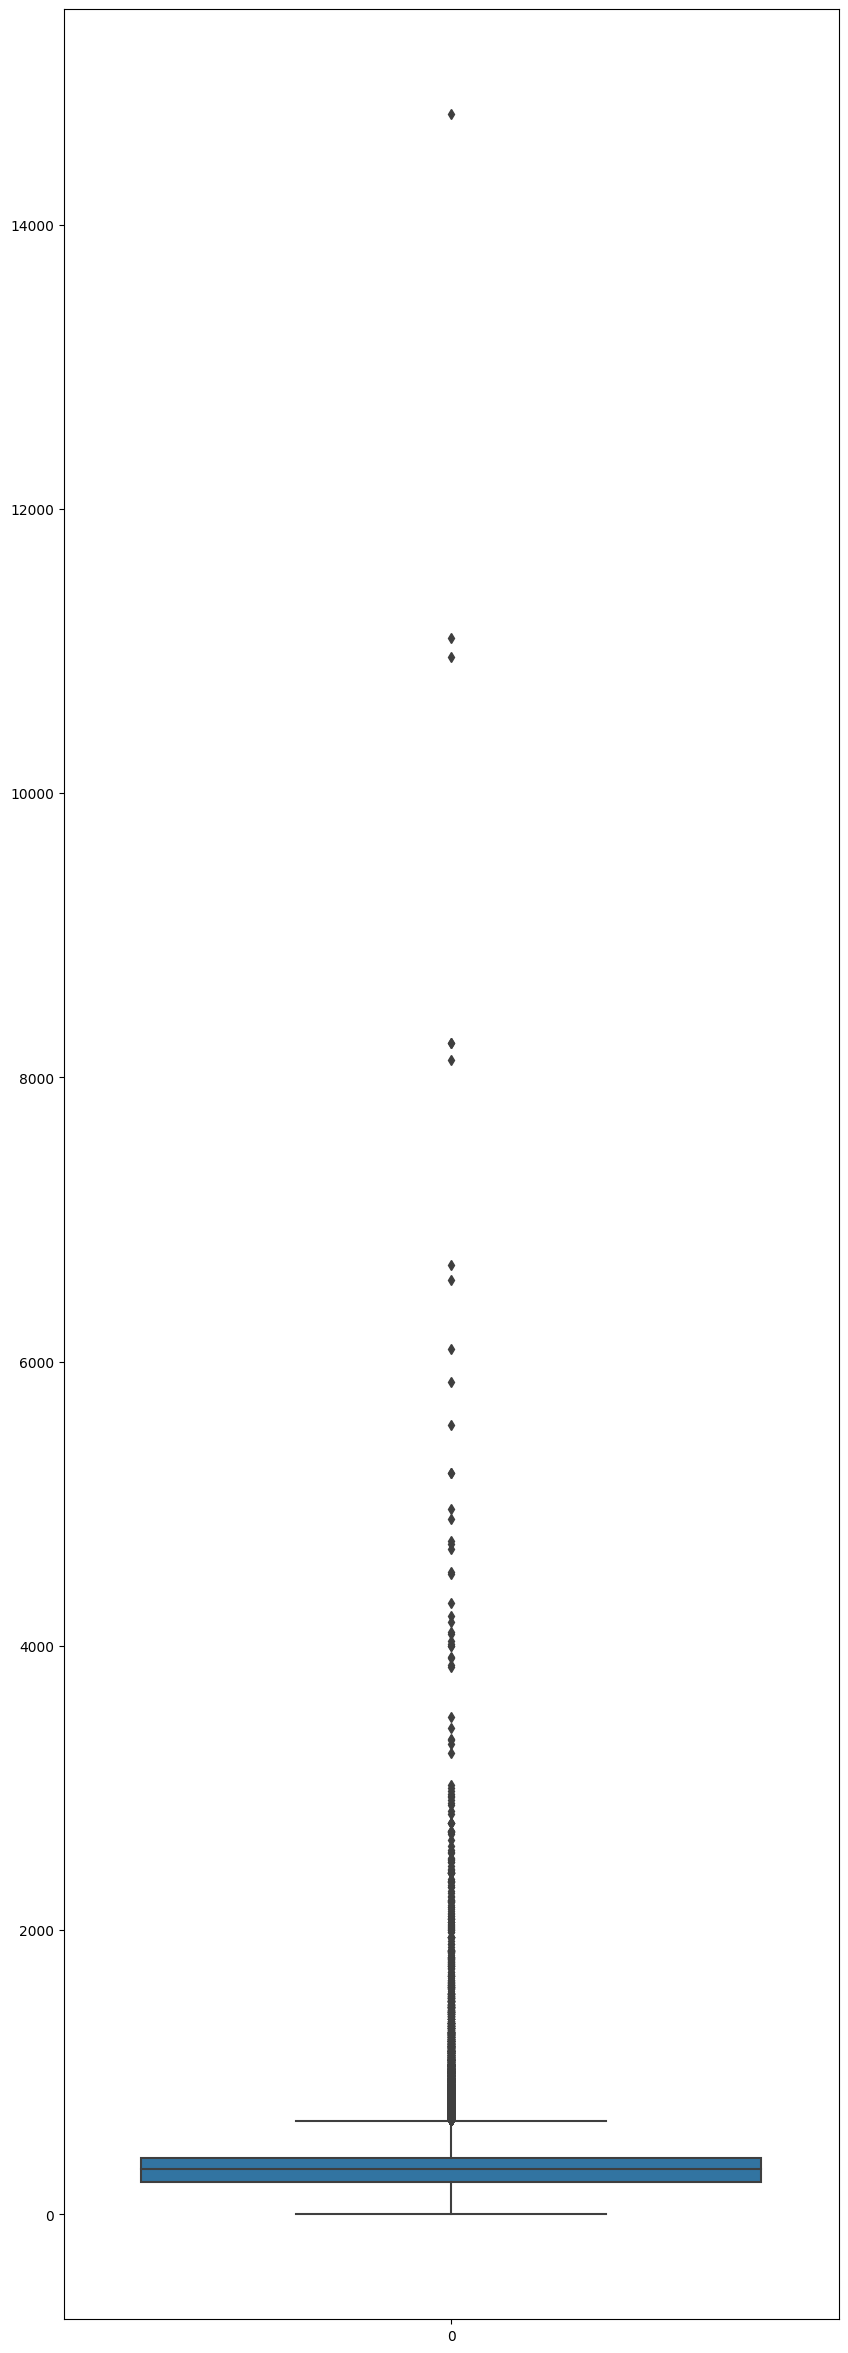

In [17]:
plt.figure(figsize=(10,30))
sns.boxplot(df['book_pages'])
plt.show()

In [19]:
col = 'book_pages'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
Q2 = Q3 - Q1

outliers = df[(df[col] < (Q1 - 1.5 * Q2)) | (df[col] > (Q3 + 1.5 * Q2))]
print(f"Выбросы в столбце {col}:")
print(len(outliers))

Выбросы в столбце book_pages:
2719


In [20]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
Q2 = Q3 - Q1

df = df[(df[col] >= (Q1 - 1.5 * Q2)) & (df[col] <= (Q3 + 1.5 * Q2))]

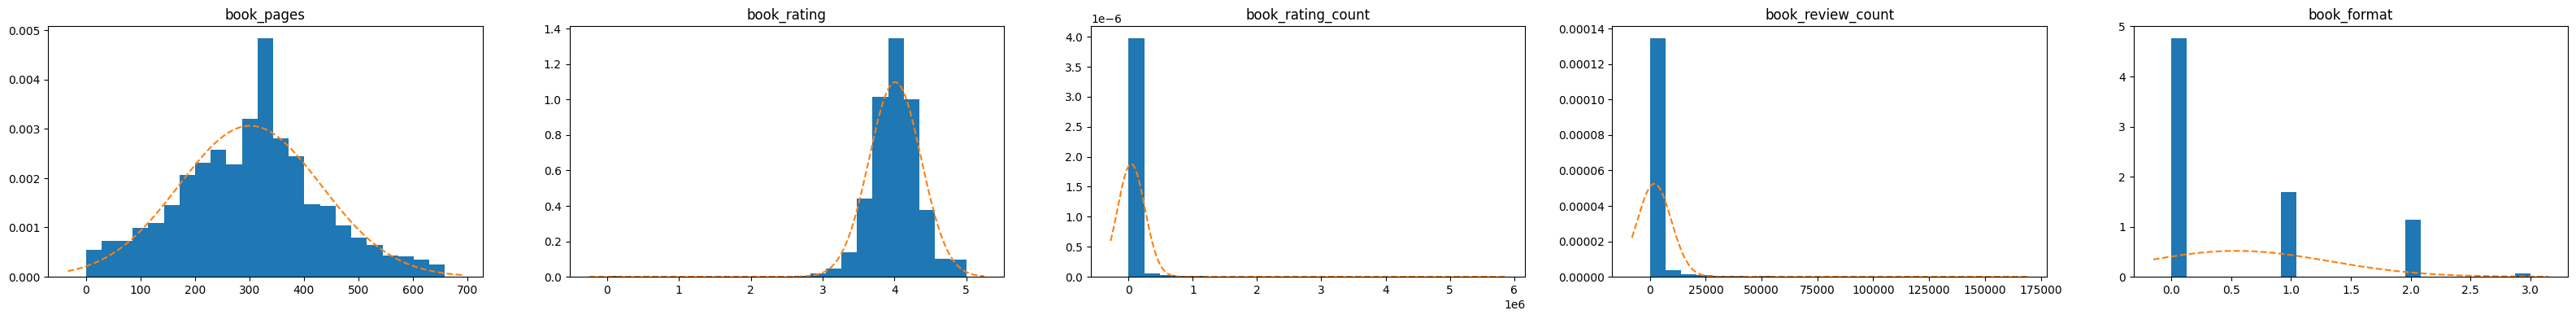

In [21]:
keys = ['book_pages', 'book_rating', 'book_rating_count', 'book_review_count', 'book_format']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

Как можно видеть по графикам, **book_rating_count**, **book_review_count** и **book_format** распределены точно не нормально 

Построим Q-Q кривую, которая покажет отклонение реального значения квантиля от его теоретического значения


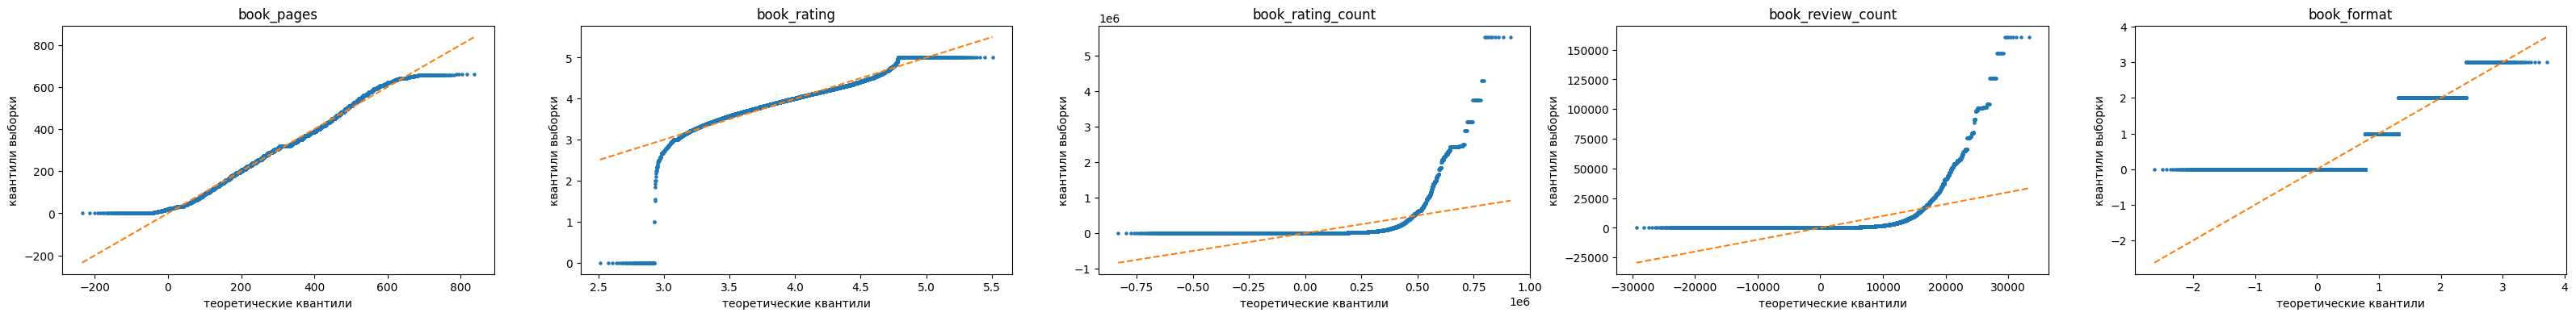

In [22]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

Еще раз убеждаемся, что **book_rating_count**, **book_review_count** и **book_format** распределены не нормально, в то время как **book_pages** и **book_rating** распределены относительно нормально 

Оценим нормальность выборок также на основании известных характеристик нормального распределения. В частности:
* Вероятность попасть в интервал от $\mu - \sigma$ до $\mu + \sigma$ равна $0.68$,
* В интервал от $\mu - 2\sigma$ до $\mu + 2\sigma$ — $0.95$,
* В интервал от $\mu - 3\sigma$ до $\mu + 3\sigma$ — $0.997$.

Если рассчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными

In [ ]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

book_pages
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9042644288405549
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9743106696352115
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9885254324370611

book_rating
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7216989210481247
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9583832848090427
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9936632985100189

book_rating_count
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9462236684363761
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9749957184449392
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9849289261859907

book_review_count
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9280698749785923
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9660900839184792
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9801335845178969

book_format
1 sigma(s)
	theoretical:	0.6826894921370859
	samp

Из всех параметров **book_rating** ближе всего к нормальному распределению, **book_pages** немного дальше, скорее всего из-за того, что в выборке есть книги большого объема: 5000 страниц и выше

# Визуализация

Проверим гопотезу о том, что существует зависимость между **book_rating** и **book_pages** 

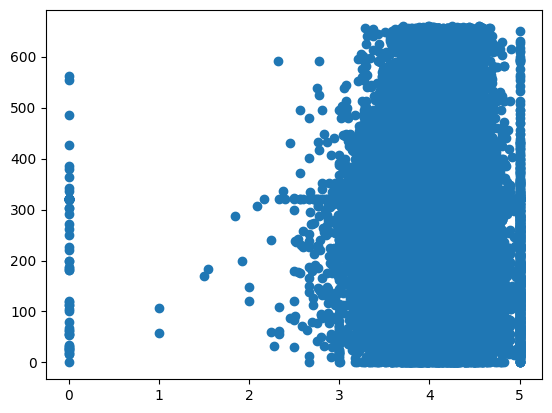

In [23]:
plt.scatter(df['book_rating'], df['book_pages'])
plt.show()

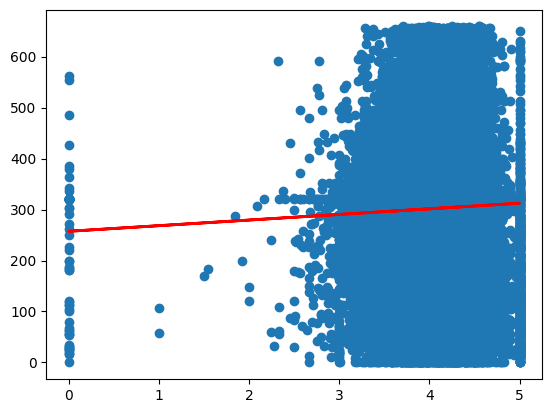

In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np
model =  LinearRegression()
x = np.array(df['book_rating'].tolist()).reshape((-1, 1))
y = df['book_pages'].tolist()
model.fit(x, y)
y_pred = model.predict(x)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red', linewidth=2);
plt.show()

# Проверим гипотезы

Дисперсионный анализ Фишера определяет, есть ли статистически значимые различия между средними значениями двух или более групп данных. Он используется для проверки гипотезы о том, что средние значения во всех группах равны, и показывает, насколько вероятно, что различия между группами являются случайными

True означает, что различия между группами статистически значимы

In [27]:
def var_analise(df, df1, df2, f):
  all1 = df1.shape[0]
  all2 = df2.shape[0]
  res1_mean = df1[f].mean()
  res2_mean = df2[f].mean()
  res_mean = df[f].mean()
  SS_b = all1 * (res1_mean - res_mean) ** 2 + all2 * (res2_mean - res_mean) ** 2
  SS_w = ((df1[f] - res1_mean) ** 2).sum() + ((df2[f]- res2_mean) ** 2).sum()

  k = 2
  n = all1 + all2
  k1 = k - 1
  k2 = n - k
  sigma2_b = SS_b / k1
  sigma2_w = SS_w / k2
  sigma2_b, sigma2_w

  F = sigma2_b / sigma2_w

  alpha = 0.05

  t = stats.f.ppf(1 - alpha, k1, k2)

  return F>t

# Верно ли, что объемные книги оценивают лучше, чем средние по объему?

In [ ]:
df1 = df[df['book_pages'] <= df['book_pages'].mean()]
df2 = df[df['book_pages'] > df['book_pages'].mean()]

df['book_pages'].mean()

398.01524233601646

In [ ]:
var_analise(df, df1, df2, 'book_rating')

True

In [ ]:
res1_mean = df1['book_rating'].mean()
res2_mean = df2['book_rating'].mean()

print(f'Less than 1000 pages: {res1_mean}, more than 1000 pages {res2_mean}')

Less than 1000 pages: 4.031745862253071, more than 1000 pages 4.113726708074534


Оценка у толстых книг в среднем выше. Скорее всего большие по объему книги читают ценители литературы/критики, а обычные люди предпочитают не брать книги больше 398 страниц 

# Зависит ли рейтинг от количества жанров?

In [25]:
df1 = df[df['book_rating'] <= 4]
df2 = df[df['book_rating'] > 4]

In [28]:
var_analise(df, df1, df2, 'genre_count')

True

In [29]:
res1_mean = df1['genre_count'].mean()
res2_mean = df2['genre_count'].mean()

print(f'Rating is less than 4: {res1_mean}, rating is more than 4: {res2_mean}')

Rating is less than 4: 5.7002910569753995, rating is more than 4: 5.468397418965322


# Есть ли зависимость между **book_review_count** и **book_rating_count**?

<ipython-input-30-09711d70d59b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


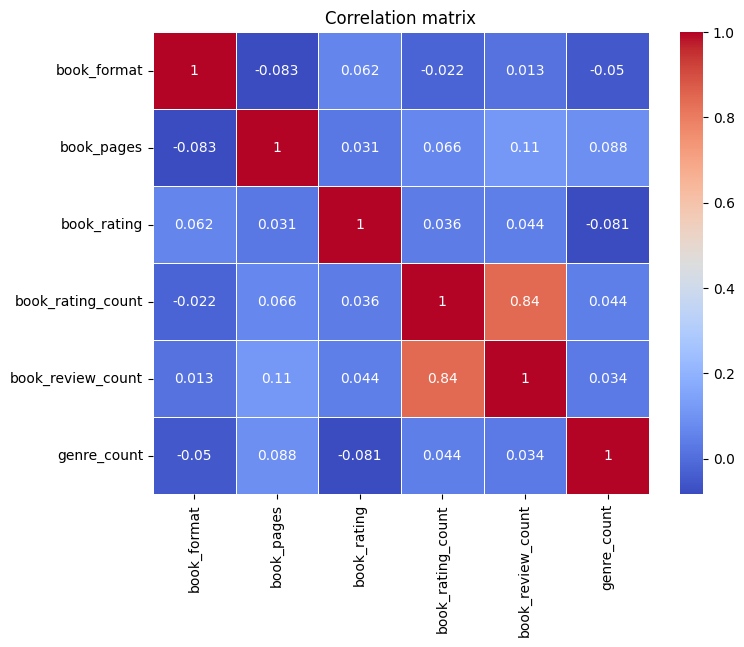

In [30]:
plt.figure(figsize = (8,6))

corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

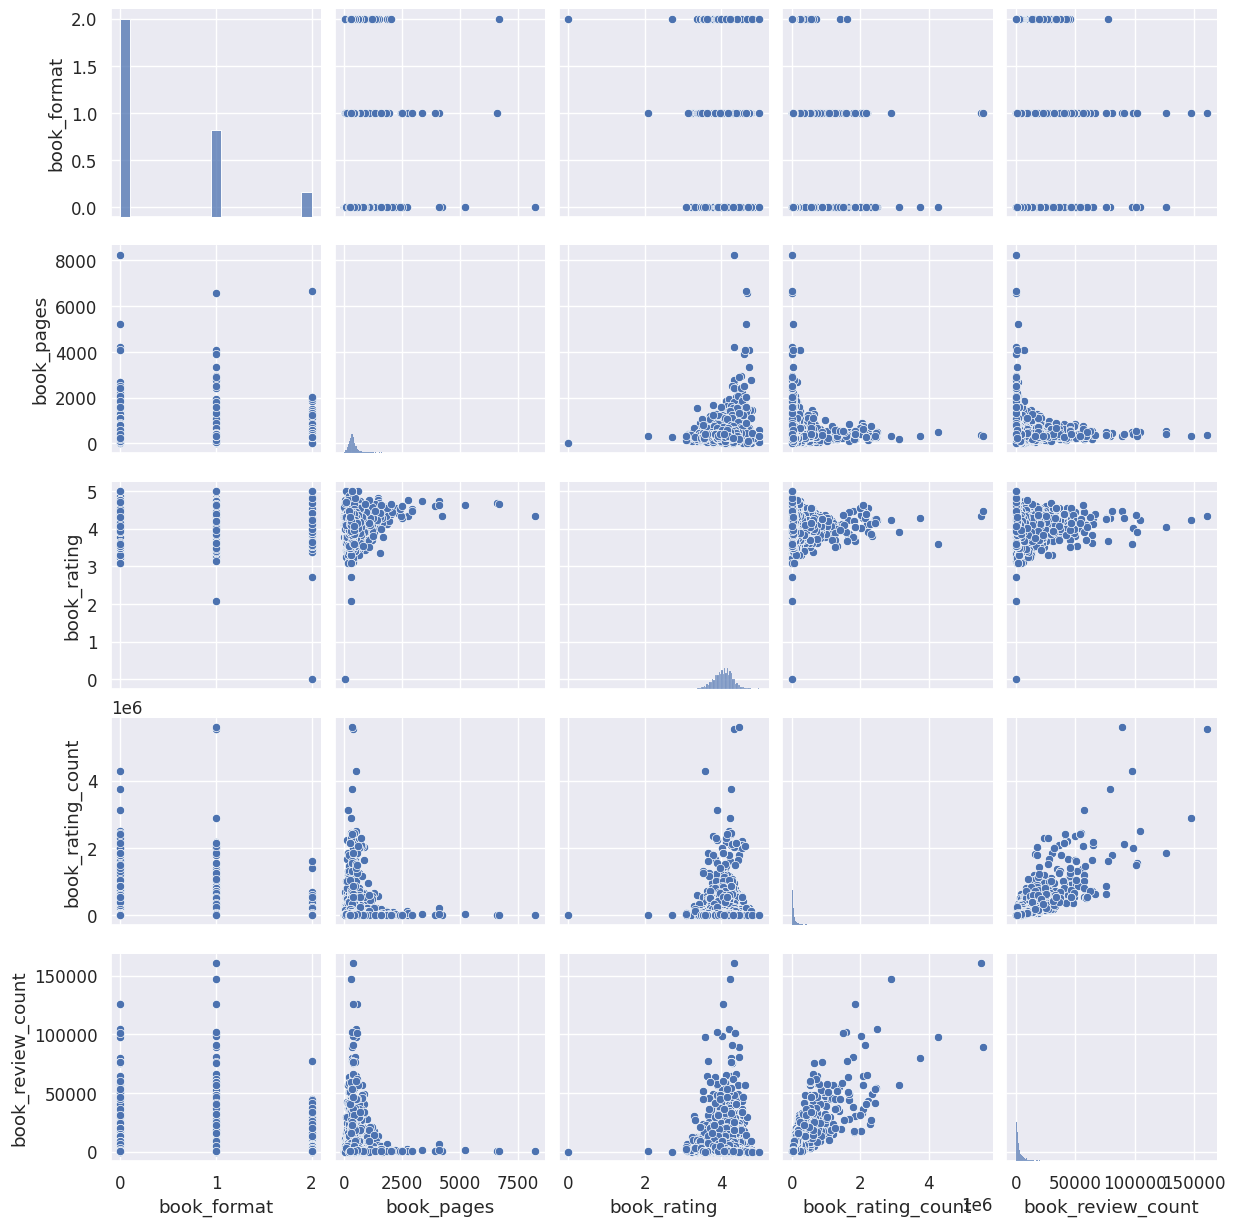

In [ ]:
sns.pairplot(df)
plt.show()

Как мы видим из heatmap и pairplot, существует зависимость между **book_rating_count** и **book_review_count**

То есть процент людей, которые после оценки пишут отзыв, примерно один и тот же 

# Верно ли, что у книг с оценкой меньше 4 отзывов меньше, чем у книг с хорошим рейтингом?

In [ ]:
df1 = df[df['book_rating'] <= 4]
df2 = df[df['book_rating'] > 4]

In [ ]:
var_analise(df, df1, df2, 'book_review_count')

False

In [ ]:
res1_mean = df1['book_review_count'].mean()
res2_mean = df2['book_review_count'].mean()

print(f'Rating is less than 4: {res1_mean}, rating is more than 4: {res2_mean}')

Rating is less than 4: 4444.428633031479, rating is more than 4: 4761.473295454545


Гипотеза не подтвердилась: если книга имеет оценку больше 4, это не значит, что у нее будет больше отзывов

# Верно ли, что электронные книги имеют более высокий рейтинг?

In [31]:
df1 = df[df['book_format'] <= 1]
df2 = df[df['book_format'] == 1]

In [32]:
var_analise(df, df1, df2, 'book_rating')

True

In [33]:
res1_mean = df1['book_rating'].mean()
res2_mean = df2['book_rating'].mean()

print(f'Rating of paper books: {res1_mean}, rating of ebooks {res2_mean}')

Rating of paper books: 3.995874994251023, rating of ebooks 3.97902813075103


Электронные книги имеют оценку чуть выше

# Выводы

*   Рейтинг книг распределен относительно нормально, это позволяет проверить гипотезы о зависимости разных параметров и рейтинга
*   Подтвердилось предположение, что объемные книги оценивают лучше, так как до них скорее всего доходят ценители литературы 
* Не подтвердилась гипотеза о существовании зависимости между рейтингом и количеством отзывов
* Верно утверждение, что существует зависимость между количеством отзывов и количеством оценок: примерно одинаковый процент людей доходит до написания отзыва после оценки 
* Самый популярный жанр - Fantasy
* Самый популярный формат - мягкая обложка 